<a href="https://colab.research.google.com/github/Aladdin60/Project-Silver-swift/blob/main/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original Data Stationarity Check:
ADF Statistic: -4.426829
p-value: 0.000266
Critical Values:
   1%, -3.5812576580093696
Critical Values:
   5%, -2.9267849124681518
Critical Values:
   10%, -2.6015409829867675


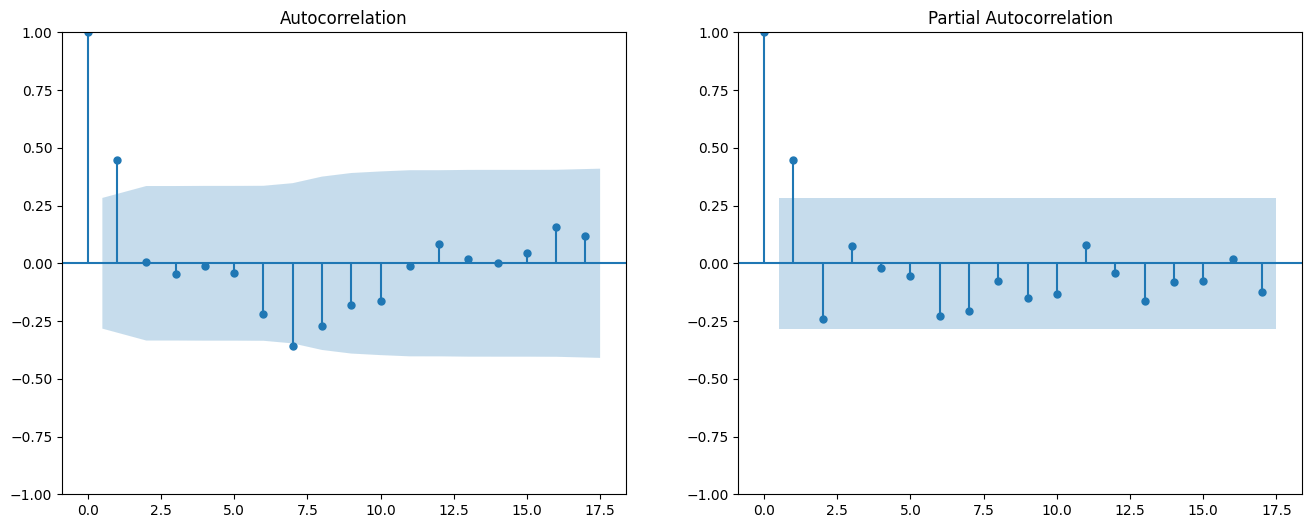

                               SARIMAX Results                                
Dep. Variable:              Cash Flow   No. Observations:                   36
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -152.316
Date:                Mon, 27 May 2024   AIC                            312.632
Time:                        05:42:56   BIC                            318.966
Sample:                    01-31-2020   HQIC                           314.843
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0508      8.921      0.678      0.498     -11.434      23.535
ar.L1          0.4262      0.235      1.815      0.070      -0.034       0.887
ma.L1          0.5077      0.290      1.752      0.0

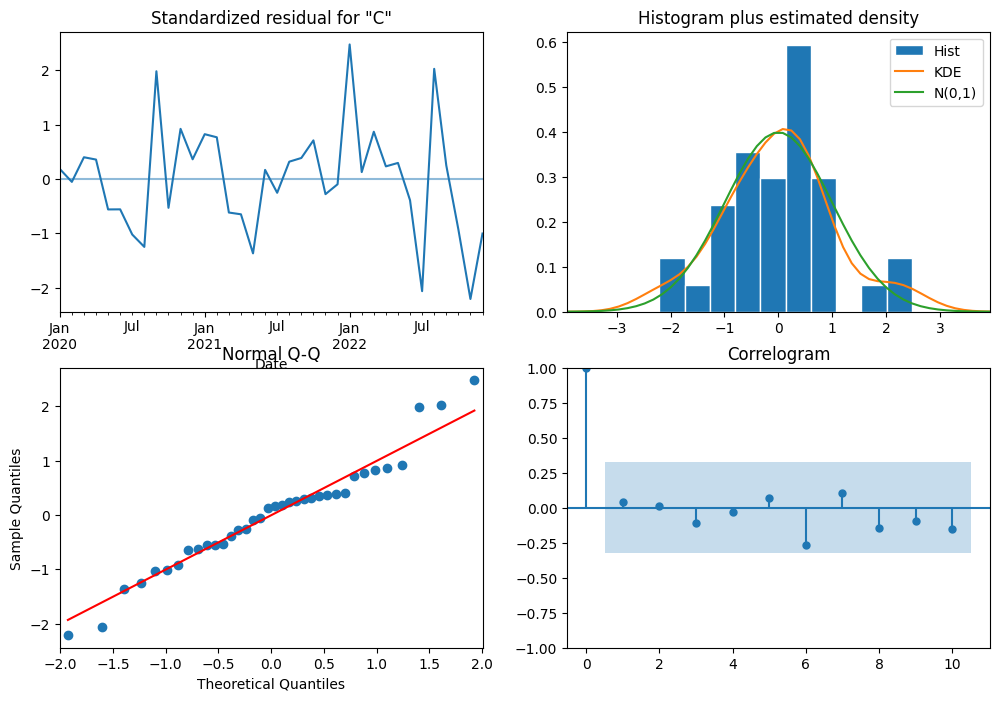

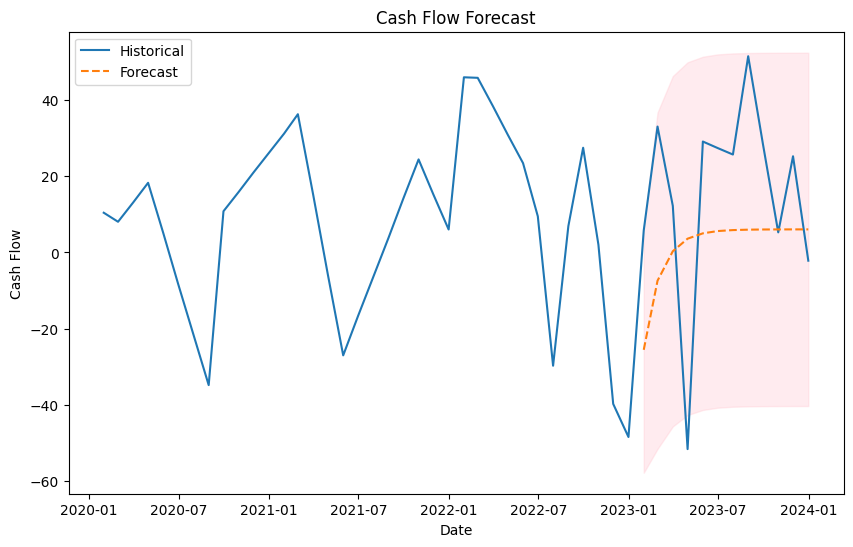

MAE: 25.028548338782443
MSE: 853.5478649129101
MAPE: 145.54362198487559%


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load your data
data = pd.read_excel('time.xlsx', index_col='Date', parse_dates=True)

# Remove duplicate indices
data = data[~data.index.duplicated(keep='first')]

# Ensure the date index is continuous and has a frequency
data = data.asfreq('M')  # Use 'ME' for month end frequency

# If there are any missing values, we can interpolate them
data['Cash Flow'] = data['Cash Flow'].interpolate()

# Function to check stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

# Check for stationarity
print("Original Data Stationarity Check:")
check_stationarity(data['Cash Flow'])

# Plot ACF and PACF to identify p and q
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(data['Cash Flow'], ax=axes[0])
plot_pacf(data['Cash Flow'], ax=axes[1])
plt.show()

# Split the data into training and testing sets
forecast_steps = 12  # e.g., forecast for the next 12 periods
train = data.iloc[:-forecast_steps]
test = data.iloc[-forecast_steps:]

# Since data is stationary, d = 0
p, d, q = 1, 0, 1  # Adjust these values based on ACF and PACF plots

# Fit ARIMA model
model = ARIMA(train['Cash Flow'], order=(p, d, q))
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Model Diagnostics
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

# Forecast
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(10, 6))
plt.plot(data['Cash Flow'], label='Historical')
forecast_index = pd.date_range(start=train.index[-1], periods=forecast_steps+1, freq='M')[1:]
plt.plot(forecast_index, forecast_mean, label='Forecast', linestyle='--')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Cash Flow')
plt.title('Cash Flow Forecast')
plt.legend()
plt.show()

# Evaluation
mae = mean_absolute_error(test['Cash Flow'], forecast_mean[:len(test)])
mse = mean_squared_error(test['Cash Flow'], forecast_mean[:len(test)])
epsilon = 1e-10  # Small value to avoid division by zero
mape = np.mean(np.abs((test['Cash Flow'] - forecast_mean[:len(test)]) / (test['Cash Flow'] + epsilon))) * 100

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'MAPE: {mape}%')
